In [18]:
from src.chessboard import *

DATA_DIR = 'c:\\Users\\demle\\University\\pod\\VCS\\project_new\\data_new'

filenames = os.listdir(DATA_DIR)
N_files = len(filenames)

print(N_files)


606


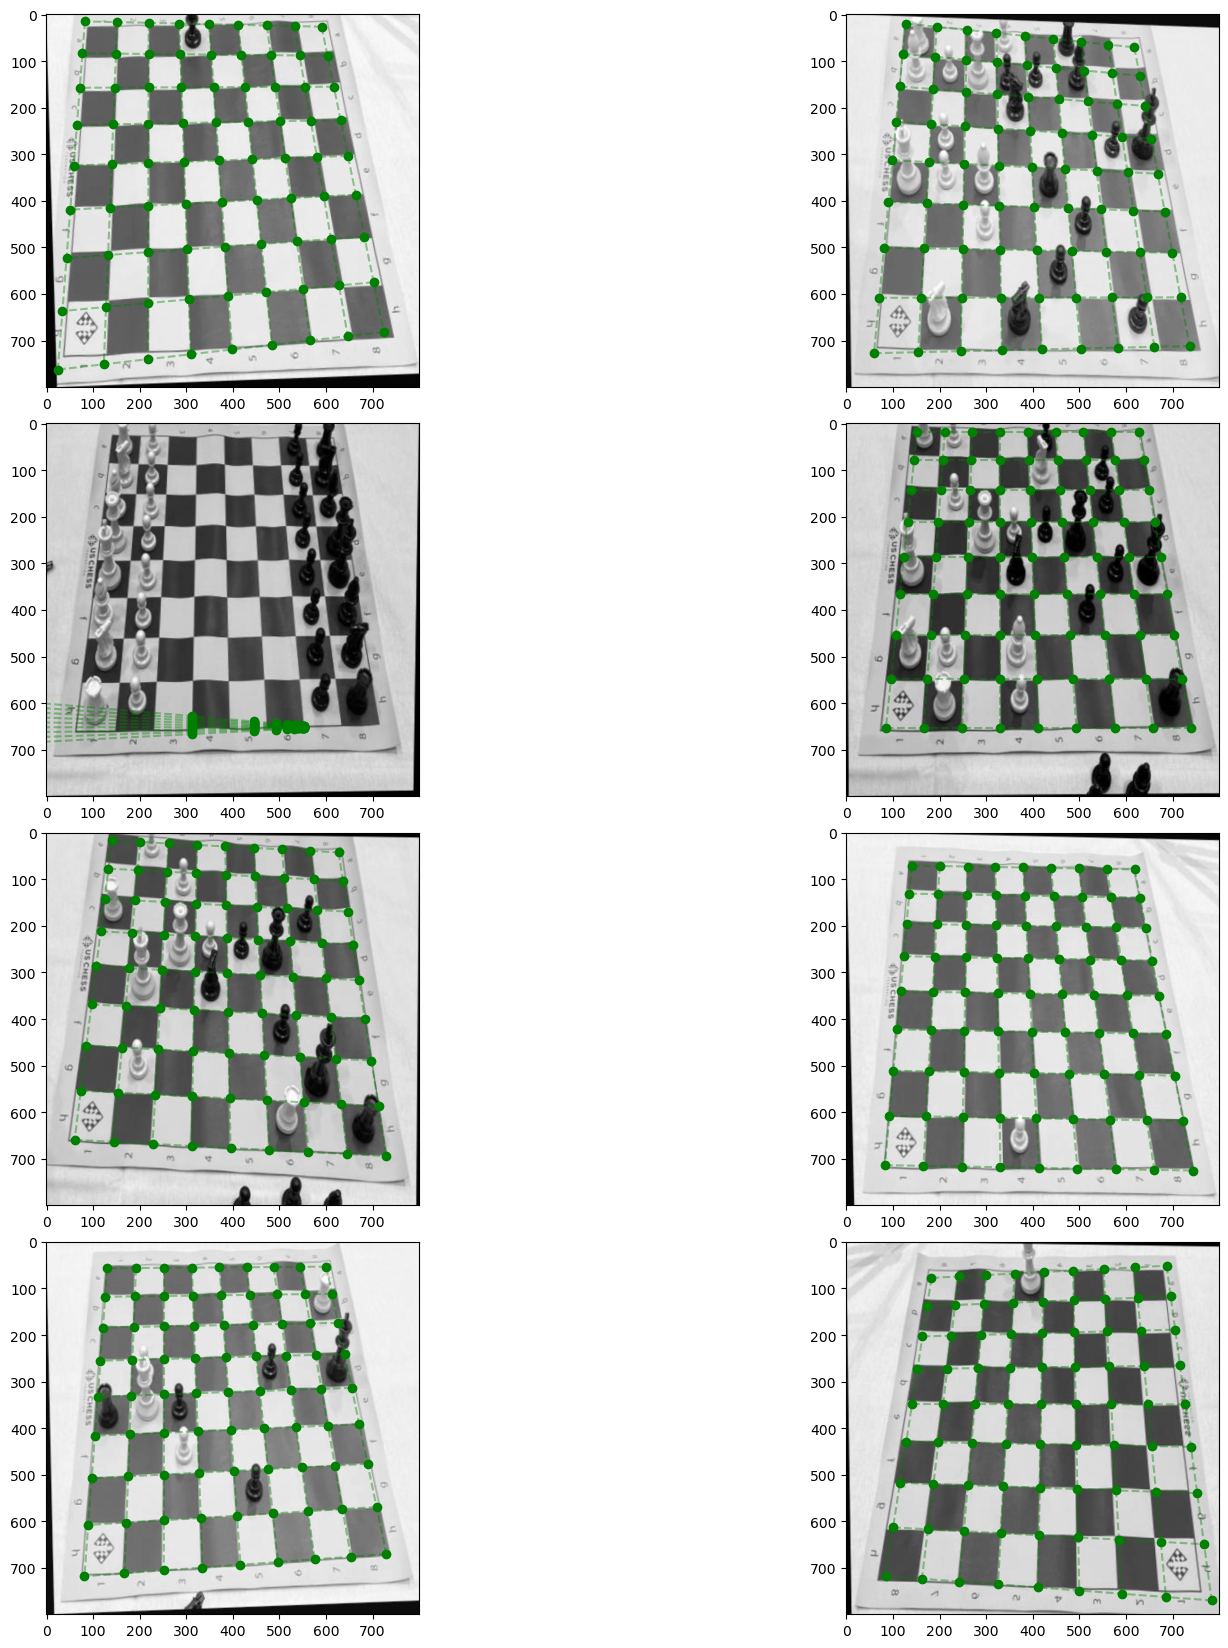

In [4]:
########################## TEST A BUNCH OF DIFFERENT CHESSBOARDS

import random

fig,axs = plt.subplots(4,2,figsize=[20,20])
fig.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
FILENAMES = [os.path.join(DATA_DIR,fn) for fn in random.sample(filenames,8)]

for ax,file in zip(axs.flatten(),FILENAMES):

    img = load_skimage(file)
    best_chessboard = fit_chessboard(img)

    best_chessboard.plot_chessboard(ax)
    ax.imshow(img,cmap='gray')

In [19]:
# grab just one that works
from skimage.io import imread


FILEPATH=os.path.join(DATA_DIR,filenames[80]) # 80 works and is a good example
img = downsample(imread(FILEPATH))
gray = rgb2gray(img)
best_chessboard = fit_chessboard(gray)

In [20]:
# BUILD THE CLASSES NOTATION

# look how they are originally defined
import yaml
def read_yaml(file_path):
    with open(file_path, 'r') as file:
        try:
            yaml_data = yaml.safe_load(file)
            return yaml_data
        except yaml.YAMLError as e:
            print(f"Error reading YAML file: {e}")

# Provide the path to your YAML file
file_path = 'c:\\Users\\demle\\University\\pod\\VCS\\project_new\\yolo\\data.yaml'
yaml_dict = read_yaml(file_path)
print(yaml_dict['names'])

# let's build another look up table for classes that matches exactly the FEN notation
fen_classes = [
    'TEST',
    'b',
    'k',
    'n',
    'p',
    'q',
    'r',
    'B',
    'K',
    'N',
    'P',
    'Q',
    'R'
]

print(fen_classes)

['bishop', 'black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']
['TEST', 'b', 'k', 'n', 'p', 'q', 'r', 'B', 'K', 'N', 'P', 'Q', 'R']


In [21]:
from ultralytics import YOLO
import torch


model = YOLO('c:\\Users\\demle\\University\\pod\\VCS\\project_new\\yolo\\runs\\detect\\best_train\\weights\\best.pt')
device = 0
model.to(device)

# Run batched inference on a list of images (just one tho)
result = model(FILEPATH,conf=0.8)[0]  # return a list of Results objects


image 1/1 c:\Users\demle\University\pod\VCS\project_new\data_new\239c409d5c09b493fed01a70a3cda4bc_jpg.rf.8f3596ebdf348f77b1bde7b51557bf0f.jpg: 640x640 2 black-bishops, 1 black-king, 1 black-knight, 8 black-pawns, 1 black-queen, 2 black-rooks, 2 white-bishops, 1 white-king, 2 white-knights, 8 white-pawns, 1 white-queen, 2 white-rooks, 18.0ms
Speed: 5.0ms preprocess, 18.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


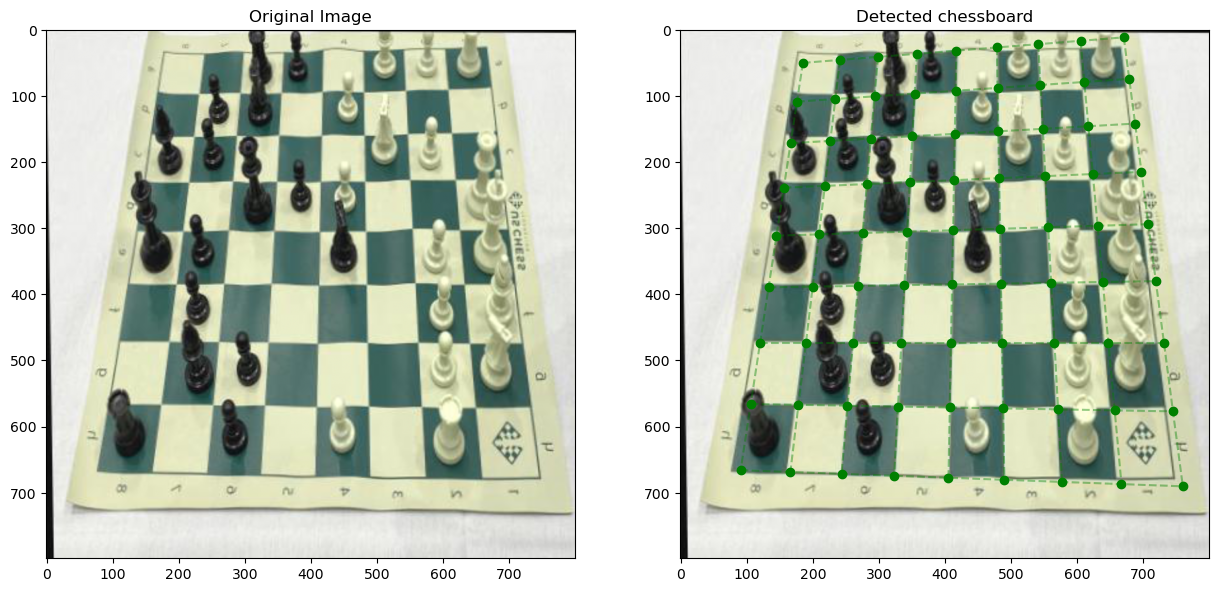

In [22]:
# Plot result

fig,axs=plt.subplots(1,2,figsize=[15,20])

best_chessboard.plot_chessboard(axs[1])
for ax in axs: ax.imshow(img)
axs[0].set_title('Original Image')
axs[1].set_title('Detected chessboard')


plt.show()

In [13]:
# we want to build a matrix representation of the chessboard
matrix = (np.ones((8,8))).astype(str)
matrix.fill('e')
matrix

array([['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e']], dtype='<U32')

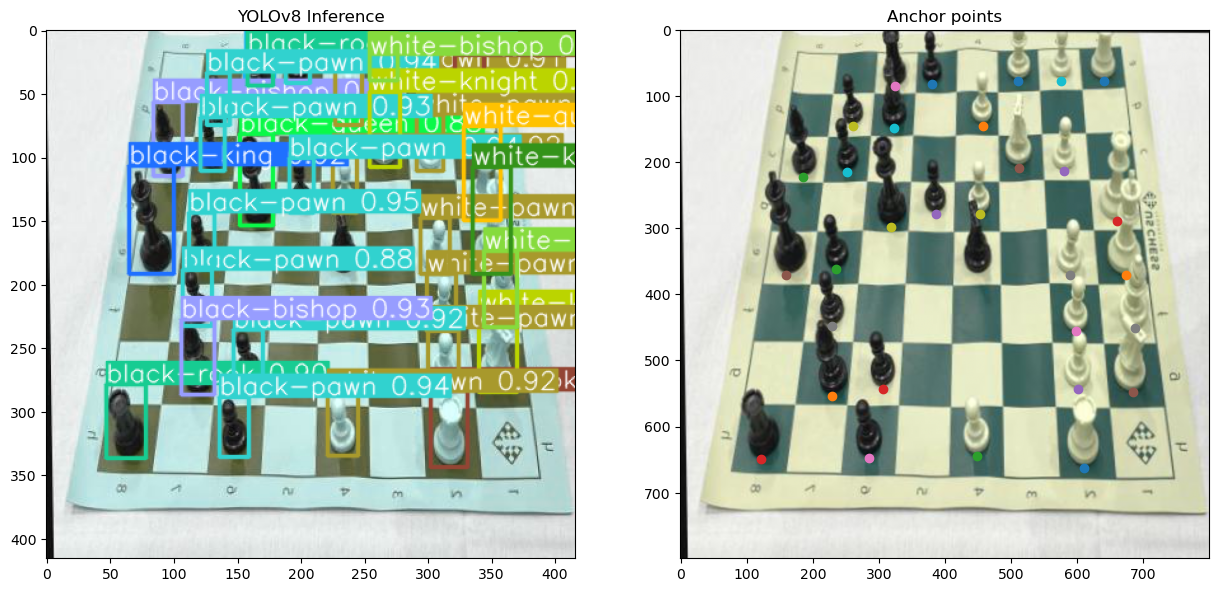

In [23]:
fig,axs = plt.subplots(1,2,figsize=[15,10])
axs[1].imshow(img)

# now we loop through the results of the cnn
for box in result.boxes:

    class_num = int(box.cls.item())
    class_str = fen_classes[class_num]
    
    # now compute the barycenter of each box
    # that will be our "anchor point"
    # x_piece = (box.xywhn[0,0] - box.xywhn[0,2]).cpu().numpy()
    # y_piece = box.xywhn[0,1].cpu().numpy()

    x_piece = (box.xyxy[0,2].cpu().numpy() + box.xyxy[0,0].cpu().numpy())/2
    y_piece = box.xyxy[0,3].cpu().numpy() 

    # we need to fix the dimensions to match the chessboard processed image
    W_chessboard,H_chessboard,C=img.shape
    W_orig,H_orig=result.orig_shape

    ratio_W = W_chessboard/W_orig
    ratio_H = H_chessboard/H_orig

    x_piece *= ratio_W
    y_piece *= ratio_H


    axs[1].scatter(x_piece,y_piece)

    # which cell is it?
    try:
        i,j = best_chessboard.return_indices((x_piece,y_piece))
        matrix[i,j] = class_str
    except:
        next
    
axs[1].set_title('Anchor points')
axs[0].imshow(result.plot())
axs[0].set_title('YOLOv8 Inference')
plt.show()

In [11]:
def generate_FEN(
    matrix,
    player_to_move : str,
    white_can_short_castle : bool,
    white_can_long_castle : bool,
    black_can_short_castle : bool,
    black_can_long_castle : bool,
    en_passant_target_square = '-',
    halfmove_clock= 0, # number of halfmoves since last capture or pawn advance
    fullmove_number= 0 # number of full moves

):
    assert (player_to_move=='w' or player_to_move=='b')
    fen_string = ''
    num_empty_spaces = 0
    for line in matrix:
        num_empty_spaces=0
        for entry in line:

            if entry =='e':
                num_empty_spaces += 1
            else:
                if num_empty_spaces != 0: fen_string+=str(num_empty_spaces)
                fen_string+=entry
                num_empty_spaces=0
        if num_empty_spaces != 0: fen_string+=str(num_empty_spaces)
        fen_string += '/'
    fen_string=fen_string[:-1]
    fen_string += ' '+player_to_move+' '

    if (white_can_long_castle+white_can_short_castle+black_can_long_castle+black_can_short_castle == 0): fen_string+= '-'
    else:
        if white_can_short_castle:
            fen_string+='K'
        if white_can_long_castle:
            fen_string+='Q'
        if black_can_short_castle:
            fen_string+='k'
        if black_can_long_castle:
            fen_string+='q'
    
    fen_string+=' '+en_passant_target_square+' '
    fen_string+=str(halfmove_clock)+' '+str(fullmove_number)

    return fen_string
            

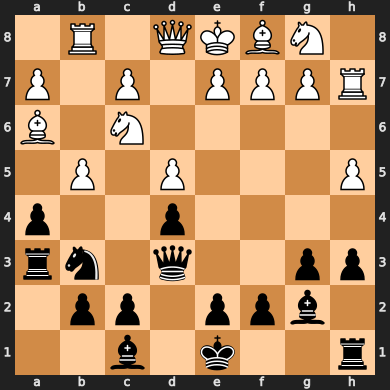

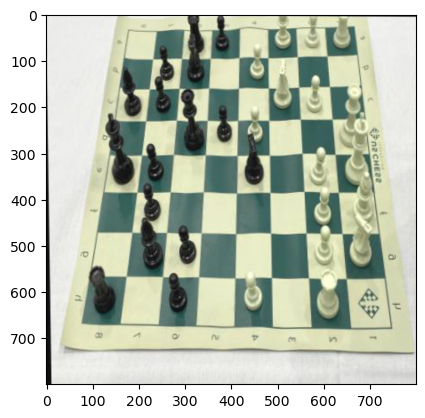

In [12]:
import chess

fig,axs = plt.subplots()



axs.imshow(img)
fen_string = generate_FEN(np.rot90(matrix[:,:]),'w',True,True,True,True) # need some manual input here
chess.Board(fen_string)

In [9]:
FILEPATH

'c:\\Users\\demle\\University\\pod\\VCS\\project_new\\data_new\\239c409d5c09b493fed01a70a3cda4bc_jpg.rf.8f3596ebdf348f77b1bde7b51557bf0f.jpg'